# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

> **Tip**: Quoted sections like this will provide helpful instructions on how to navigate and use a Jupyter notebook.

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, you will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. You will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. You will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, you should start by asking questions you might want to understand about the bike share data. Consider, for example, if you were working for Motivate. What kinds of information would you want to know about in order to make smarter business decisions? If you were a user of the bike-share service, what factors might influence how you would want to use the service?

**Question 1**: Write at least two questions related to bike sharing that you think could be answered by data.

**Answer**: 

* How far are people willing to travel out of their way to utilize bike share? Where is the convenience trade-off?
* What pattern is there for bike movement around time of the day? 


<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **However, you do not need to download the data yourself.** The data has already been collected for you in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. Run the first code cell below to load some packages and functions that you'll be using in your analysis. Then, complete the second code cell to print out the first trip recorded from each of the cities (the second line of each data file).

> **Tip**: You can run a code cell like you formatted Markdown cells above by clicking on the cell and using the keyboard shortcut **Shift** + **Enter** or **Shift** + **Return**. Alternatively, a code cell can be executed using the **Play** button in the toolbar after selecting it. While the cell is running, you will see an asterisk in the message to the left of the cell, i.e. `In [*]:`. The asterisk will change into a number to show that execution has completed, e.g. `In [1]`. If there is output, it will show up as `Out [1]:`, with an appropriate number to match the "In" number.

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
import pandas
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        trip_reader = csv.DictReader(f_in)
        first_trip = trip_reader.__next__()
        pprint(first_trip)
        
    return (city, first_trip)

data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

If everything has been filled out correctly, you should see below the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. When you set up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

You will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two. It also turns out that there are some trips in the New York city dataset that do not have an attached user type. Since we don't have enough information to fill these values in, just leave them as-is for now.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    """
    duration = 0
    if city == 'NYC':
        value = float(datum['tripduration'])
        duration = value/60
    elif city == 'Chicago':
        value = float(datum['tripduration'])
        duration = value/60
    elif city == 'Washington':
        value = float(datum['Duration (ms)'])
        duration = value/60000
    return duration
    
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    """
    
    if city == 'NYC':
        datetime_object = datetime.strptime((datum['starttime']), '%m/%d/%Y %H:%M:%S')
    elif city == 'Chicago':
        datetime_object = datetime.strptime((datum['starttime']), '%m/%d/%Y %H:%M')
    elif city == 'Washington':
        datetime_object = datetime.strptime((datum['Start date']), '%m/%d/%Y %H:%M')
    else: 
        datetime_object = None
    month = int(datetime_object.strftime('%m'))
    hour = int(datetime_object.strftime('%H'))
    day_of_week = datetime_object.strftime('%A')
        
    return(month, hour, day_of_week)

tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    """
    
    if city == 'NYC':
        user_type = datum['usertype']
    elif city == 'Chicago':
        user_type = datum['usertype']
    elif city == 'Washington':
        user_type = datum['Member Type']
    else: 
        user_type = None
    
    return user_type

tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Registered'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Now, use the helper functions you wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        trip_reader = csv.DictReader(f_in)

        for row in trip_reader:
            new_point = {}
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'] = time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row, city)[2]
            new_point['user_type'] = type_of_user(row, city)

            trip_writer.writerow(new_point)
            

In [7]:
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}
for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Registered')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


> **Tip**: If you save a jupyter Notebook, the output from running code blocks will also be saved. However, the state of your workspace will be reset once a new session is started. Make sure that you run all of the necessary code blocks from your previous session to reestablish variables and functions before picking up where you last left off.

<a id='eda'></a>
## Exploratory Data Analysis

Now that you have the data collected and wrangled, you're ready to start exploring the data. In this section you will write some code to compute descriptive statistics from the data. You will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**: Unsuprisingly, NYC has the most trips at 276,081. NYC also has the highest proportion of trips made by subscribers at 89.1%. Chicago has the highest proportion of trips by short-term customers at just under 24%.

In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        
        n_subscribers = 0
        n_customers = 0
        
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            elif row['user_type'] == 'Customer':
                n_customers += 1
            elif row['user_type'] == 'Registered':
                n_subscribers += 1
            elif row['user_type'] == 'Casual':
                n_customers += 1
                
        n_total = n_subscribers + n_customers
        
        return(n_subscribers, n_customers, n_total)

In [9]:
data_file = './examples/BayArea-Y3-Summary.csv'
print(number_of_trips(data_file))

(5666, 633, 6299)


In [10]:
data_file = './data/Chicago-2016-Summary.csv'
print(number_of_trips(data_file))

(54982, 17149, 72131)


In [11]:
data_file = './data/NYC-2016-Summary.csv'
print(number_of_trips(data_file))

(245896, 30185, 276081)


In [12]:
data_file = './data/Washington-2016-Summary.csv'
print(number_of_trips(data_file))

(51753, 14573, 66326)


> **Tip**: In order to add additional cells to a notebook, you can use the "Insert Cell Above" and "Insert Cell Below" options from the menu bar above. There is also an icon in the toolbar for adding new cells, with additional icons for moving the cells up and down the document. By default, new cells are of the code type; you can also specify the cell type (e.g. Code or Markdown) of selected cells from the Cell menu or the dropdown in the toolbar.

Now, you will write your own code to continue investigating properties of the data.

**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: 

1. What is the average trip length for each city?
 * Chicago - 17 minutes
 * NYC - 16 minutes
 * Washington - 19 minutes
 
2. What proportion of rides made in each city are longer than 30 minutes?
 * Chicago - 8.3%
 * NYC - 7.3%
 * Washington - 10.8%

In [13]:
def tot_length(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        minutes = 0
        
        # tally up ride types
        for row in reader:
            time = float(row['duration'])
            minutes = time + minutes
            
        return(minutes)

def trip_longer_than_30(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        long_trips = 0
        
        # tally up ride types
        for row in reader:
            if float(row['duration']) > 30:
                long_trips += 1
        
        return(long_trips)


def avg_metrics(filename):
    
    tot_trips = number_of_trips(filename)[2]  
    
    avg_length = tot_length(filename)/tot_trips
    
    prop_long_trips = (trip_longer_than_30(filename)/tot_trips)*100

    return(avg_length, prop_long_trips)

In [14]:
data_file = './examples/BayArea-Y3-Summary.csv'
print(avg_metrics(data_file))

(14.038656929671422, 3.5243689474519764)


In [15]:
data_file = './data/Chicago-2016-Summary.csv'
print(avg_metrics(data_file))

(16.563629368787335, 8.332062497400562)


In [16]:
data_file = './data/NYC-2016-Summary.csv'
print(avg_metrics(data_file))

(15.853659312545064, 7.321402052296247)


In [17]:
data_file = './data/Washington-2016-Summary.csv'
print(avg_metrics(data_file))

(18.93287355913721, 10.83888671109369)


**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: In Chicago, the average customer's ride is 2.5 times the length of subscribers. 

In [31]:
def dig_deeper(filename,  usertype):
    df = pandas.read_csv(filename)
    df = df.loc[df['user_type'].str.lower() == usertype.lower()]
    
    avg_length = sum(df['duration']) / len(df)
    
    return(avg_length, usertype)

In [32]:
data_file = './examples/BayArea-Y3-Summary.csv'
print(dig_deeper(data_file, 'Customer'))

(54.551211163770319, 'Customer')


In [33]:
data_file = './data/Chicago-2016-Summary.csv'
print(dig_deeper(data_file, 'Customer'))

(30.979781133982506, 'Customer')


In [34]:
print(dig_deeper(data_file, 'Subscriber'))

(12.067201690250076, 'Subscriber')


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

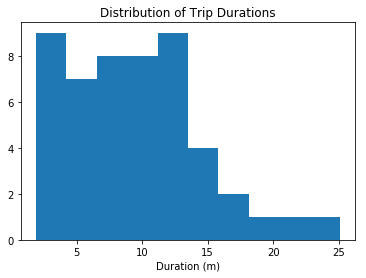

In [35]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

You will now use these functions to create a histogram of the trip times for the city you selected in question 4c. Don't separate the Subscribers and Customers for now: just collect all of the trip times and plot them.

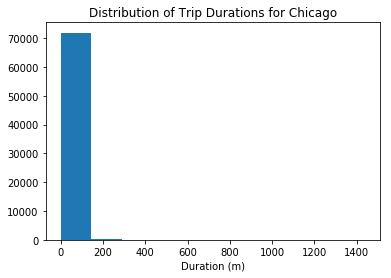

In [65]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##

data_file = './data/Chicago-2016-Summary.csv'
data_file = pandas.read_csv(data_file)
data = data_file['duration'].tolist()
plt.hist(data)
plt.title('Distribution of Trip Durations for Chicago')
plt.xlabel('Duration (m)')
plt.show()


If you followed the use of the `.hist()` and `.show()` functions exactly like in the example, you're probably looking at a plot that's completely unexpected. The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, you will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**: In Chicago, the most frequent ride length for subscribers is between 5 and 10 minutes. For customers, it's between 20 and 25 minutes. Both are skewed heavily to the left with long right tails. 

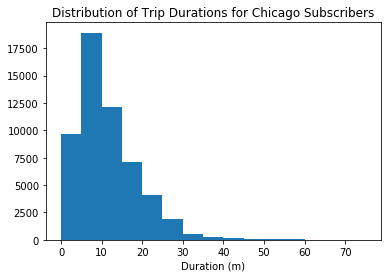

In [66]:
## Use this and additional cells to answer Question 5. ##
df = data_file
subs = df.loc[df['user_type'].str.lower() == 'subscriber']
data = subs['duration'].tolist()
plt.hist(data, range=(0, 75), bins = (0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75))
plt.title('Distribution of Trip Durations for Chicago Subscribers')
plt.xlabel('Duration (m)')
plt.show()

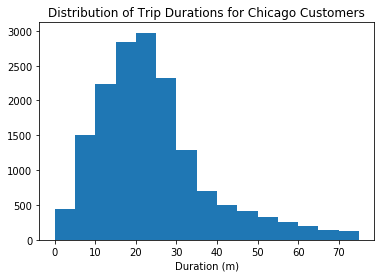

In [67]:
custs = df.loc[df['user_type'].str.lower() == 'customer']
data = custs['duration'].tolist()
plt.hist(data, range=(0, 75), bins = (0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75))
plt.title('Distribution of Trip Durations for Chicago Customers')
plt.xlabel('Duration (m)')
plt.show()

<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, you've performed an initial exploration into the data available. You have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, you have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is your turn to continue the exploration in a direction that you choose. Here are a few suggestions for questions to explore:

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

If any of the questions you posed in your answer to question 1 align with the bullet points above, this is a good opportunity to investigate one of them. As part of your investigation, you will need to create a visualization. If you want to create something other than a histogram, then you might want to consult the [Pyplot documentation](https://matplotlib.org/devdocs/api/pyplot_summary.html). In particular, if you are plotting values across a categorical variable (e.g. city, user type), a bar chart will be useful. The [documentation page for `.bar()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar) includes links at the bottom of the page with examples for you to build off of for your own use.

**Question 6**: Continue the investigation by exploring another question that could be answered by the data available. Document the question you want to explore below. Your investigation should involve at least two variables and should compare at least two groups. You should also use at least one visualization as part of your explorations.

**Answer**: In Chicago, there is clearly a peak month of the year- July. Peak season is June to September. This peak is clearly driven by customers who take more trips in July than any other month by far. The second half of the year usage is much more consistent for subscribers, though there is a small bump in the summer months.

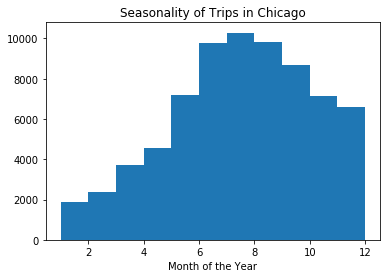

In [78]:
## Use this and additional cells to continue to explore the dataset. ##
## Once you have performed your exploration, document your findings  ##
## in the Markdown cell above.                                       ##

df = data_file
data = df['month'].tolist()
plt.hist(data, bins = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12))
plt.title('Seasonality of Trips in Chicago')
plt.xlabel('Month of the Year')
plt.show()

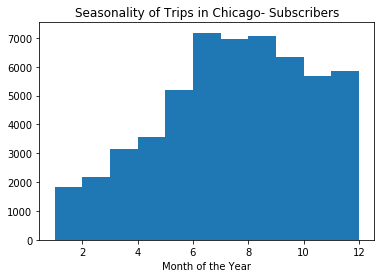

In [79]:
subs = df.loc[df['user_type'].str.lower() == 'subscriber']
data = subs['month'].tolist()
plt.hist(data, bins = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12))
plt.title('Seasonality of Trips in Chicago- Subscribers')
plt.xlabel('Month of the Year')
plt.show()

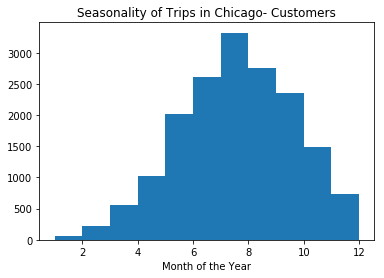

In [80]:
subs = df.loc[df['user_type'].str.lower() == 'customer']
data = subs['month'].tolist()
plt.hist(data, bins = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12))
plt.title('Seasonality of Trips in Chicago- Customers')
plt.xlabel('Month of the Year')
plt.show()

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: I would be interested in understanding more about the books I'm reading- do the authors skew one gender? Are there certain topics more prominent that others? Am I reading books as they're trendy? What is the average length of time it takes me to read a book? What is the averaeg number of pages I'm reading per day? This could probably be collected from my Goodreads data. 

> **Tip**: If we want to share the results of our analysis with others, we aren't limited to giving them a copy of the jupyter Notebook (.ipynb) file. We can also export the Notebook output in a form that can be opened even for those without Python installed. From the **File** menu in the upper left, go to the **Download as** submenu. You can then choose a different format that can be viewed more generally, such as HTML (.html) or
PDF (.pdf). You may need additional packages or software to perform these exports.